In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegressionCV

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

# Подготовка данных

Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

In [2]:
na_values=['-99',
           '-99.0',
           '$null$',
           '\\N',
           'Не задано',
           'null',
           'NULL',
           'NOT_IND',
           '',
           -99,
           -99.0
          ]

In [3]:
train = pd.read_csv('features.csv', index_col='match_id', keep_default_na=False, na_values=na_values)
test = pd.read_csv('features_test.csv', index_col='match_id', keep_default_na=False, na_values=na_values)

In [4]:
# Признаки связанные с итогом матча 

drop_fithures = ['duration',
                 'tower_status_radiant',
                 'tower_status_dire',
                 'barracks_status_radiant',
                 'barracks_status_dire'
                ]
train.drop(drop_fithures, axis=1, inplace=True)

In [5]:
# Выделение таргета

train_X = train.drop(columns='radiant_win')
train_y = train['radiant_win']

In [6]:
train_X.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

Ответ : Потом подумаю

Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [7]:
# Замена NaN на медианы

for col in train_X.columns:
    train_X[col] = train_X[col].fillna(train_X[col].median())

Какой столбец содержит целевую переменную? Запишите его название.

Ответ : radiant_win

Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

# Построение моделей 

## Подход 1: градиентный бустинг "в лоб"


In [9]:
kf = KFold(train_y.size, n_folds=5, shuffle=True, random_state=42)

### Подбираем оптимальное число деревьев

In [10]:
scores = []
nums = [10, 20, 30, 50, 100, 250, 300, 350]
for n in nums:
    print(f'n_estimators = {n}')
    model = GradientBoostingClassifier(n_estimators=n, random_state=42)
    start_time = datetime.datetime.now()
    model_scores = cross_val_score(model, train_X, train_y, cv=kf, scoring='roc_auc', n_jobs=-1)
    print ('Time elapsed:', datetime.datetime.now() - start_time)
    print (model_scores)
    scores.append(np.mean(model_scores))

n_estimators = 10
Time elapsed: 0:00:29.856000
[0.66335971 0.6666395  0.65940925 0.66303639 0.66882229]
n_estimators = 20
Time elapsed: 0:00:52.288000
[0.68101607 0.68340189 0.67978355 0.6827672  0.6862748 ]
n_estimators = 30
Time elapsed: 0:01:16.256000
[0.68779681 0.69035772 0.68690286 0.68936905 0.6933044 ]
n_estimators = 50
Time elapsed: 0:01:58.504000
[0.69507539 0.69670315 0.69474229 0.69846991 0.7010625 ]
n_estimators = 100
Time elapsed: 0:03:53.442000
[0.70421008 0.70574399 0.70329133 0.70743159 0.70907981]
n_estimators = 250
Time elapsed: 0:09:33.264000
[0.71472843 0.71514009 0.71403443 0.71751078 0.71801428]
n_estimators = 300
Time elapsed: 0:11:26.363000
[0.71659325 0.71644461 0.71616088 0.7193181  0.71964852]
n_estimators = 350
Time elapsed: 0:13:05.571000
[0.71775666 0.7178796  0.71723606 0.72064556 0.72065243]


In [11]:
scores

[0.6642534283486006,
 0.6826487024110748,
 0.6895461680097364,
 0.6972106485216483,
 0.7059513605094614,
 0.7158856004734699,
 0.7176330706110567,
 0.7188340628072939]

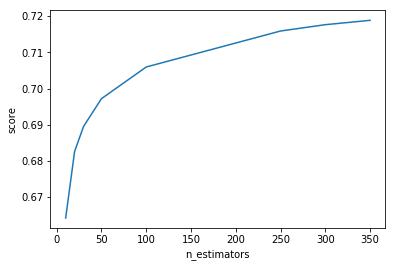

In [12]:
plt.plot(nums, scores)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()


На графике видно что до 100 деревьев наблюдается значительный прирост.<br>
При дальнейшем увелечении  n_estimators качество продолжит возрастать,но не значительно.<br>
Оптимальное колличество деревьев 250 - 300



## Подход 2: логистическая регрессия


In [8]:
#скейлинг данных

robust_scaler = RobustScaler()
robust_scaler = robust_scaler.fit(train_X)
train_X = pd.DataFrame(data=robust_scaler.transform(train_X), columns=train_X.columns.tolist())

In [21]:
train_X.head()
train_X.shape

(97230, 102)

### L1 регуляризация

In [9]:
logregCV = LogisticRegressionCV(Cs=np.logspace(-5, 5, 25), cv=5, penalty='l1', n_jobs=-1, solver="saga", scoring='accuracy', random_state=0, verbose=2)
logregCV.fit(train_X, train_y)

convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 1 seconds
convergence after 4 epochs took 2 seconds
convergence after 12 epochs took 3 seconds
convergence after 13 epochs took 4 seconds
convergence after 14 epochs took 4 seconds
convergence after 12 epochs took 3 seconds
convergence after 12 epochs took 5 seconds
convergence after 13 epochs took 5 seconds
convergence after 13 epochs took 5 seconds
convergence after 13 epochs took 5 seconds
convergence after 13 epochs took 5 seconds
convergence after 12 epochs took 4 seconds
convergence after 13 epochs took 4 seconds
convergence after 14 ep

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


convergence after 22 epochs took 4 seconds


LogisticRegressionCV(Cs=array([1.00000e-05, 2.61016e-05, 6.81292e-05, 1.77828e-04, 4.64159e-04,
       1.21153e-03, 3.16228e-03, 8.25404e-03, 2.15443e-02, 5.62341e-02,
       1.46780e-01, 3.83119e-01, 1.00000e+00, 2.61016e+00, 6.81292e+00,
       1.77828e+01, 4.64159e+01, 1.21153e+02, 3.16228e+02, 8.25404e+02,
       2.15443e+03, 5.62341e+03, 1.46780e+04, 3.83119e+04, 1.00000e+05]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-1, penalty='l1', random_state=0, refit=True,
           scoring='accuracy', solver='saga', tol=0.0001, verbose=2)

In [10]:
logregCV.C_

array([0.00825404])

In [11]:
model_coef = logregCV.coef_

In [12]:
# Создание фрейма с коэф-ми и названиями фич соответственно 

Reg_koefs_table = pd.DataFrame(list(zip(train_X.columns, np.transpose(model_coef))))
Reg_koefs_table.head()

,0,1
0,start_time,[0.028442971571817653]
1,lobby_type,[0.0]
2,r1_hero,[0.0]
3,r1_level,[0.0]
4,r1_xp,[0.051782651431902166]


In [13]:
# Заведу дубликат данных, чтобы не портить исходник

new_train_X = train_X

In [64]:
# Удаление фич с коэф-том близким к 0 

df = Reg_koefs_table
ind = -1 
for i in range(len(Reg_koefs_table)):
    ind += 1
    if Reg_koefs_table[1][i] == 0 or abs(Reg_koefs_table[1][i]) < 1.27991185e-04:
        df = df.drop(index=ind)
df = df.reset_index(drop=True)
my_list = df[0].values.tolist()
new_train_X = train_X[my_list]

In [103]:
new_train_X_1.shape

(97230, 521)

In [15]:
new_train_X.head()

,start_time,r1_xp,r1_gold,r1_lh,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,...,radiant_tpscroll_count,radiant_boots_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_first_ward_time
0,-2.013742,0.985059,0.512960,0.529412,-0.333333,0.34,0.0,-0.296337,-0.086777,0.0625,...,-0.5,-1.0,1.250,-0.466667,0.000000,0.56250,0.0,1.0,0.0,-0.923077
1,-2.011050,0.013874,-0.109141,-0.117647,1.333333,-0.02,1.0,0.540511,-0.084022,0.0625,...,-0.5,-3.0,-0.125,0.300000,0.000000,-0.25000,1.0,1.0,1.0,0.282051
2,-2.010210,0.153682,0.214188,0.647059,1.333333,0.96,0.0,0.227525,-0.384298,-0.1875,...,-0.5,2.0,-0.600,-1.433333,1.000000,0.56250,0.0,1.0,1.0,0.743590
3,-2.005662,0.644610,-0.077763,0.176471,-1.000000,-0.40,-1.0,-0.632630,-0.709366,-0.5000,...,-1.5,0.0,-0.375,-0.116667,0.571429,-0.59375,-1.5,1.0,0.0,1.102564
4,-2.003321,0.273212,-0.031378,-0.176471,0.000000,-0.46,-1.0,-0.532741,-0.691460,-0.5625,...,-1.0,1.0,1.525,0.850000,0.571429,0.68750,1.5,0.0,1.0,0.000000


### L2 регуляризация

In [16]:
logregCV = LogisticRegressionCV(Cs=np.logspace(-5, 5, 25), cv=5, penalty='l2', n_jobs=-1, solver="saga", scoring='accuracy', random_state=0, verbose=2)
logregCV.fit(new_train_X, train_y)

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 13 epochs took 4 seconds
convergence after 13 epochs took 4 seconds
rescaling...
rescaling...
convergence after 14 epochs took 4 seconds
convergence after 14 epochs took 4 seconds
convergence after 10 epochs took 3 seconds
convergence after 10 epochs took 3 seconds
convergence after 10 epochs took 3 secon

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


convergence after 25 epochs took 3 seconds


LogisticRegressionCV(Cs=array([1.00000e-05, 2.61016e-05, 6.81292e-05, 1.77828e-04, 4.64159e-04,
       1.21153e-03, 3.16228e-03, 8.25404e-03, 2.15443e-02, 5.62341e-02,
       1.46780e-01, 3.83119e-01, 1.00000e+00, 2.61016e+00, 6.81292e+00,
       1.77828e+01, 4.64159e+01, 1.21153e+02, 3.16228e+02, 8.25404e+02,
       2.15443e+03, 5.62341e+03, 1.46780e+04, 3.83119e+04, 1.00000e+05]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=0, refit=True,
           scoring='accuracy', solver='saga', tol=0.0001, verbose=2)

In [17]:
# Кросс валидация

scores = cross_val_score(logregCV, new_train_X, train_y, scoring='roc_auc')

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


convergence after 17 epochs took 2 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 13 epochs took 2 seconds
convergence after 13 epochs took 3 seconds
convergence after 13 epochs took 3 seconds
convergence after 13 epochs took 3 seconds
convergence after 10 epochs took 1 seconds
convergence after 10 epochs took 2 seconds
convergence after 10 ep

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


convergence after 24 epochs took 1 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 13 epochs took 2 seconds
convergence after 13 epochs took 2 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 16 epochs took 3 seconds
convergence after 16 epochs took 3 seconds
convergence after 10 epochs too

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


convergence after 21 epochs took 2 seconds


In [18]:
scores

array([0.73460213, 0.69747686, 0.71782805])

In [110]:
scores.mean()

0.7166356787118694

Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

Ответ: Среднйи результат кросс валидации 0.71663568, приблизительно соотносится с градиентным бустингом при 300 деревьях. Логистическая регрессия работает на порядок быстрее бустинга

Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

Ответ: С помощтю L1 регуляризации мы изначально избавились от этих признаков. Качество не изменилось, так как эти фичи не влияют на результат

In [20]:
heroes = pd.read_csv('heroes.csv')

In [21]:
heroes.head()

,id,localized_name,name
0,1,Anti-Mage,antimage
1,2,Axe,axe
2,3,Bane,bane
3,4,Bloodseeker,bloodseeker
4,5,Crystal Maiden,crystal_maiden


##### Код для формирования "мешка слов" по героям

In [90]:
hero_c = [c for c in train_X.columns if 'hero' in c]
all_heroes_id = np.unique(train_X[hero_c])
wb = {}
for id in all_heroes_id:
    # Мы используем + 0 для автоматического приведения bool-->int.
    r = [(train_X['r%d_hero' % n] == id) + 0 for n in range(1, 6)]
    d = [(train_X['d%d_hero' % n] == id) + 0 for n in range(1, 6)]
    wb['hero%s' % id] = sum(r) - sum(d)
X_pick = train_X.assign(**wb)

In [91]:
print(train_X.shape,X_pick.shape)

(97230, 102) (97230, 535)


### Снова проведем L1 и L2 регуляризацию

In [62]:
logregCV = LogisticRegressionCV(Cs=np.logspace(-5, 5, 25), cv=5, penalty='l1', n_jobs=-1, solver="saga", scoring='accuracy', random_state=0, verbose=2)
logregCV.fit(X_pick, train_y)

convergence after 1 epochs took 2 secondsconvergence after 1 epochs took 10 seconds

convergence after 1 epochs took 15 seconds
convergence after 1 epochs took 16 seconds
convergence after 1 epochs took 6 seconds
convergence after 1 epochs took 5 seconds
convergence after 1 epochs took 6 seconds
convergence after 1 epochs took 4 seconds
convergence after 1 epochs took 2 seconds
convergence after 1 epochs took 2 seconds
convergence after 1 epochs took 2 seconds
convergence after 4 epochs took 7 seconds
convergence after 12 epochs took 13 seconds
convergence after 13 epochs took 15 seconds
convergence after 14 epochs took 16 seconds
convergence after 12 epochs took 14 seconds
convergence after 12 epochs took 14 seconds
convergence after 13 epochs took 15 seconds
convergence after 13 epochs took 15 seconds
convergence after 13 epochs took 15 seconds
convergence after 13 epochs took 15 seconds
convergence after 12 epochs took 14 seconds
convergence after 13 epochs took 15 seconds
convergen

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 135 seconds
max_iter reached after 145 seconds
max_iter reached after 143 seconds
max_iter reached after 141 seconds
max_iter reached after 145 seconds
max_iter reached after 144 seconds
max_iter reached after 143 seconds
max_iter reached after 145 seconds
max_iter reached after 147 seconds
max_iter reached after 147 seconds
max_iter reached after 146 seconds
max_iter reached after 146 seconds
max_iter reached after 149 seconds
max_iter reached after 148 seconds
max_iter reached after 147 seconds
max_iter reached after 147 seconds
max_iter reached after 152 seconds
max_iter reached after 150 seconds
max_iter reached after 147 seconds
max_iter reached after 148 seconds
max_iter reached after 150 seconds
max_iter reached after 154 seconds
max_iter reached after 151 seconds
max_iter reached after 152 seconds
max_iter reached after 155 seconds
max_iter reached after 162 seconds
max_iter reached after 160 seconds
max_iter reached after 161 seconds
max_iter reached aft

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 66.1min finished


max_iter reached after 94 seconds


LogisticRegressionCV(Cs=array([1.00000e-05, 2.61016e-05, 6.81292e-05, 1.77828e-04, 4.64159e-04,
       1.21153e-03, 3.16228e-03, 8.25404e-03, 2.15443e-02, 5.62341e-02,
       1.46780e-01, 3.83119e-01, 1.00000e+00, 2.61016e+00, 6.81292e+00,
       1.77828e+01, 4.64159e+01, 1.21153e+02, 3.16228e+02, 8.25404e+02,
       2.15443e+03, 5.62341e+03, 1.46780e+04, 3.83119e+04, 1.00000e+05]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-1, penalty='l1', random_state=0, refit=True,
           scoring='accuracy', solver='saga', tol=0.0001, verbose=2)

In [63]:
logregCV.C_

array([1.])

In [112]:
model_coef_1 = logregCV.coef_
Reg_koefs_table_1 = pd.DataFrame(list(zip(X_pick.columns, np.transpose(model_coef_1))))

In [104]:
X_pick.shape

(97230, 535)

Коэффициентов близких к 0 не было найдено 

In [93]:
logregCV = LogisticRegressionCV(Cs=np.logspace(-5, 5, 25), cv=5, penalty='l2', n_jobs=-1, solver="saga", scoring='accuracy', random_state=0, verbose=2)
logregCV.fit(X_pick, train_y)

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 13 epochs took 31 seconds
convergence after 13 epochs took 31 seconds
rescaling...
rescaling...
convergence after 14 epochs took 32 seconds
convergence after 14 epochs took 32 seconds
convergence after 10 epochs took 9 seconds
convergence after 11 epochs took 10 seconds
convergence after 10 epochs took 9 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 87 seconds
max_iter reached after 87 seconds
max_iter reached after 87 seconds
max_iter reached after 89 seconds
max_iter reached after 90 seconds
max_iter reached after 91 seconds
max_iter reached after 90 seconds
max_iter reached after 86 seconds
max_iter reached after 86 seconds
max_iter reached after 87 seconds
max_iter reached after 87 seconds
max_iter reached after 87 seconds
max_iter reached after 87 seconds
max_iter reached after 88 seconds
max_iter reached after 87 seconds
max_iter reached after 87 seconds
max_iter reached after 87 seconds
max_iter reached after 87 seconds
max_iter reached after 87 seconds
max_iter reached after 87 seconds
max_iter reached after 87 seconds
max_iter reached after 88 seconds
max_iter reached after 88 seconds
max_iter reached after 87 seconds
max_iter reached after 87 seconds
max_iter reached after 86 seconds
max_iter reached after 86 seconds
max_iter reached after 86 seconds
max_iter reached after 86 seconds
max_iter reach

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 40.8min finished


max_iter reached after 60 seconds


LogisticRegressionCV(Cs=array([1.00000e-05, 2.61016e-05, 6.81292e-05, 1.77828e-04, 4.64159e-04,
       1.21153e-03, 3.16228e-03, 8.25404e-03, 2.15443e-02, 5.62341e-02,
       1.46780e-01, 3.83119e-01, 1.00000e+00, 2.61016e+00, 6.81292e+00,
       1.77828e+01, 4.64159e+01, 1.21153e+02, 3.16228e+02, 8.25404e+02,
       2.15443e+03, 5.62341e+03, 1.46780e+04, 3.83119e+04, 1.00000e+05]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=0, refit=True,
           scoring='accuracy', solver='saga', tol=0.0001, verbose=2)

In [105]:
scores_1 = cross_val_score(logregCV, X_pick, train_y, scoring='roc_auc')

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 59 seconds
max_iter reached after 58 seconds
max_iter reached after 59 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 57 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 59 seconds
max_iter reached after 59 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 57 seconds
max_iter reached after 57 seconds
max_iter reached after 57 seconds
max_iter reached after 57 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reach

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 27.8min finished


max_iter reached after 40 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 13 epochs took 8 seconds
convergence after 13 epochs took 8 seconds
rescaling...
rescaling...
convergence after 13 epochs took 9 seconds
convergence after 14 epochs took 9 seconds
convergence after 10 epochs took 6 seconds
convergence after 11 epochs took 7 seconds
convergence after 1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 58 seconds
max_iter reached after 57 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 57 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 57 seconds
max_iter reached after 57 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 59 seconds
max_iter reached after 59 seconds
max_iter reached after 58 seconds
max_iter reached after 59 seconds
max_iter reached after 57 seconds
max_iter reached after 58 seconds
max_iter reached after 59 seconds
max_iter reached after 59 seconds
max_iter reached after 58 seconds
max_iter reached after 59 seconds
max_iter reach

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 27.1min finished


convergence after 100 epochs took 39 seconds
max_iter reached after 39 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 13 epochs took 8 seconds
convergence after 13 epochs took 8 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 16 epochs took 10 seconds
convergence after 16 epochs took 10 s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 58 seconds
max_iter reached after 57 seconds
max_iter reached after 58 seconds
max_iter reached after 57 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 57 seconds
max_iter reached after 58 seconds
max_iter reached after 57 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 57 seconds
max_iter reached after 59 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reached after 61 seconds
max_iter reached after 61 seconds
max_iter reached after 61 seconds
max_iter reached after 60 seconds
max_iter reached after 57 seconds
max_iter reached after 58 seconds
max_iter reached after 57 seconds
max_iter reached after 58 seconds
max_iter reached after 60 seconds
max_iter reached after 59 seconds
max_iter reached after 61 seconds
max_iter reached after 59 seconds
max_iter reached after 58 seconds
max_iter reached after 58 seconds
max_iter reach

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 28.6min finished


max_iter reached after 53 seconds


### Предсказательная способность модели

In [111]:
scores_1

array([0.74310002, 0.72478553, 0.74171076])

In [109]:
scores_1.mean()

0.7365321018507566

Лучшая получившиеся модель - это линейная регрессия.<br> Резульат: **0.7365321018507566**